# Analysis Template: Inhibition
Updated 6/4/25 NF

In [1]:
import time
start = time.time()

In [2]:
#enables autoreloding of modules
%load_ext autoreload
%autoreload 2

from htbam_db_api.htbam_db_api import LocalHtbamDBAPI
from htbam_analysis.analysis.experiment import HTBAMExperiment

#enable inline plotting of matplotlib figures
%matplotlib inline

#set the figure format to SVG
%config InlineBackend.figure_format = 'svg'

## 1. Connect DB Api

In [3]:
### PARAMETERS:
EGFP_SLOPE = 91900.03
EGFP_SLOPE_CONC_UNITS = 'nM' #RFU/nM

root = './ic50_data/'
db_conn = LocalHtbamDBAPI(
    standard_curve_data_path= root + 'd3_2_StandardSeries_Analysis.csv',
    standard_name="standard_5-FAM", 
    standard_substrate="5-FAM", 
    standard_units="uM",
    kinetic_data_path= root+ 'd3_TitrationSeries_Analysis.csv',
    kinetic_name="kinetics_AVI4516", 
    kinetic_substrate="NSP 4/5", 
    kinetic_units="nM")

htbam_experiment = HTBAMExperiment(db_conn)


Connected to database.
Experiment found with the following runs:
['standard_5-FAM', 'kinetics_AVI4516', 'button_quant']


## 2. Enzyme Quant

In [4]:
from htbam_analysis.analysis.fitting import transform_data

button_quant_data = htbam_experiment.get_run('button_quant')  # retrieve our button quant data
button_concentrations = transform_data(button_quant_data, 
                                       apply_to='luminance',
                                       store_as='concentration',
                                       function = lambda x: x / EGFP_SLOPE,  # convert RFU to nM
                                       flatten = False,
                                       data_type = 'concentration_data')                       # flatten array from (n_conc, n_time, n_chambers) to (n_chambers)
htbam_experiment.set_run('enzyme_concentrations', button_concentrations)     # save the fit results

Existing run data not found. Fetching from database.


In [5]:
htbam_experiment.plot_enzyme_concentration_chip(analysis_name='enzyme_concentrations', units=EGFP_SLOPE_CONC_UNITS)

## 2. Product Standards

In [6]:
from htbam_analysis.analysis.fitting import fit_luminance_vs_concentration

# For demonstration purposes, I'm doing this in 3 lines
# we can either keep it "exposed" like this (might be useful?)
# Or provide a simple wrapper fx that looks like:
# htbam_experiment.fit_standard_curve(experiment_name = 'standard_5-FAM', analysis_name='htbam_experiment')

standard_experiment_data = htbam_experiment.get_run('standard_5-FAM')       # retrieve our raw data
standard_fits = fit_luminance_vs_concentration(standard_experiment_data)    # perform a fit
htbam_experiment.set_run('standard_5-FAM_fits', standard_fits)              # save the fit results

Existing run data not found. Fetching from database.
Fit slopes for 1792 wells.
Elapsed 2.166 seconds.


In [7]:
htbam_experiment.plot_standard_curve_chip('standard_5-FAM_fits', 'standard_5-FAM')

## 3. Fit Initial Rates

In [8]:
from htbam_analysis.analysis.fitting import fit_luminance_vs_time

kinetics_experiment_data = htbam_experiment.get_run('kinetics_AVI4516')       # retrieve our raw data
kinetics_fits = fit_luminance_vs_time(kinetics_experiment_data, start_timepoint = 1, end_timepoint=6)      # perform a fit, skipping the first timepoint
htbam_experiment.set_run('kinetics_AVI4516_fits', kinetics_fits)                # save the fit results

Existing run data not found. Fetching from database.
Fit slopes for 1792 wells at 12 concentrations.
Elapsed 0.024 seconds.


In [9]:
htbam_experiment.plot_initial_rates_chip(analysis_name='kinetics_AVI4516_fits', experiment_name='kinetics_AVI4516')#, remove_0_point=True) # plot the initial rates

/home/freitas/workspace/htbam_sprint/htbam_analysis/src/htbam_analysis/analysis/experiment.py:216: RuntimeWarning:

Mean of empty slice



## 4. Filter initial rates

In [10]:
# These are the "Masks" we use to select which data we want.

from htbam_analysis.analysis.filtering import filter_expression_cutoff, filter_initial_rates_positive_cutoff, filter_initial_rates_r2_cutoff, filter_standard_curve_r2_cutoff

kinetics_fits = htbam_experiment.get_run('kinetics_AVI4516_fits')       # retrieve our raw data

# Initial Rates:
initial_rates_r2_mask =         filter_initial_rates_r2_cutoff(kinetics_fits, r2_cutoff=0.8) # 0.9 R2
initial_rates_positive_mask =   filter_initial_rates_positive_cutoff(kinetics_fits)          # positive slope

# Standard Curve:
standard_curve_r2_mask =        filter_standard_curve_r2_cutoff(standard_fits, kinetics_fits, r2_cutoff=0.9) # 0.9 R2

# Expression:
expression_mask =               filter_expression_cutoff(button_concentrations, kinetics_fits, expression_cutoff=1) # 1 nM

# Save the masks to the experiment
htbam_experiment.set_run('initial_rates_r2_mask', initial_rates_r2_mask)
htbam_experiment.set_run('initial_rates_positive_mask', initial_rates_positive_mask)
htbam_experiment.set_run('standard_curve_r2_mask', standard_curve_r2_mask)
htbam_experiment.set_run('expression_mask', expression_mask)



In [11]:
# Plot the masks (Do one at a time)
#htbam_experiment.plot_mask_chip(mask_name='initial_rates_r2_mask')
htbam_experiment.plot_mask_chip(mask_name='initial_rates_positive_mask')
#htbam_experiment.plot_mask_chip(mask_name='standard_curve_r2_mask')
#htbam_experiment.plot_mask_chip(mask_name='expression_mask')

In [12]:
#htbam_experiment.apply_mask(run_name="", save_as="", mask_names=['name'])

# TODO, send in the names of the saved mask objects, not the mask data itself.
htbam_experiment.apply_mask(run_name='kinetics_AVI4516_fits', 
                            dep_variables = ['slope', 'intercept'], 
                            save_as = 'kinetics_AVI4516_fits_masked',
                            mask_names = ['initial_rates_r2_mask', 'initial_rates_positive_mask', 'standard_curve_r2_mask', 'expression_mask'])


In [13]:
htbam_experiment.plot_initial_rates_chip(analysis_name='kinetics_AVI4516_fits_masked', experiment_name='kinetics_AVI4516')#, remove_0_point=True) # plot the initial rates

In [14]:
htbam_experiment.plot_initial_rates_vs_concentration_chip(analysis_name='kinetics_AVI4516_fits_masked', x_log=True) # plot the initial rates

/home/freitas/workspace/htbam_sprint/htbam_analysis/src/htbam_analysis/analysis/experiment.py:275: RuntimeWarning:

Mean of empty slice



# N.F. 6/3/25: Need to finish the fitting code

## 5. Fit Inhibition Constant:

In [15]:
# I've written MM here, but it will be IC50
from htbam_analysis.analysis.fitting import fit_initial_rates_vs_concentration_with_function, mm_model, inhibition_model

kinetics_fits_masked = htbam_experiment.get_run('kinetics_AVI4516_fits_masked')       # retrieve our raw data
IC50_fits = fit_initial_rates_vs_concentration_with_function(data = kinetics_fits_masked,
                                model_func = inhibition_model)
htbam_experiment.set_run('kinetics_AVI4516_IC50_fits', IC50_fits)                # save the fit results

Successfully fit nonlinear model for 973 wells.
Elapsed 1.197 seconds.


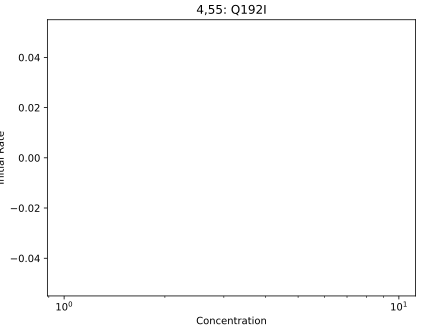

In [16]:
htbam_experiment.plot_initial_rates_vs_concentration_chip(analysis_name='kinetics_AVI4516_fits_masked', 
                                                            model_fit_name='kinetics_AVI4516_IC50_fits',
                                                            x_log=True) # plot the initial rates

In [17]:
elapsed = time.time() - start
print(f"Elapsed time: {elapsed:.2f} seconds")

Elapsed time: 14.86 seconds


In [18]:
# Add masking, as above
# Add filtering step

In [19]:
#htbam_experiment.plot_MM_chip('kinetics_AVI4516_MM', show_average_fit=True)

## 6. Export to CSV

In [20]:
#htbam_experiment.export_ic50_result_csv(path_to_save=root,
#                                        run_name='kinetics_0')